This Notebook is for analyzing the city-data Dataset.
We start by importing the neccessary libraries.

In [84]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
import mplcursors
import datetime as dt
import seaborn as sns

reading the Dataset

In [54]:
data = pd.read_csv('../city_data.csv', delimiter='|')

Preprocessing the dataset:

Adjusting the columns,
Splitting the city-country column into two seperate columns for better readability, 
removing a column with two many missing values,
and removing duplicate rows.


In [55]:
new_header = data.iloc[0]
data = data[1:]
data.columns = new_header

cities = []
states = []
for i in range(len(data)):
    if ',' in data.iloc[i]["City"]:
        city_and_state = data.iloc[i]["City"].split(",")
    elif '.' in data.iloc[i]["City"]:
        city_and_state = data.iloc[i]["City"].split(".")
    else:
        city_and_state = data.iloc[i]["City"].split(";")
         
    cities.append(city_and_state[0])
    if len(city_and_state) > 1:
        states.append(city_and_state[1])
    else:
        states.append("")

data.drop(columns=['City'], inplace=True)
data.insert(0, 'City', cities)
data.insert(1, 'Country', states)

data.drop(columns=['Average Price Groceries'], inplace=True)

data.drop_duplicates(inplace=True)

Changing the dtype of numeric columns

In [56]:
for col in data.columns:
    try:
        data[col] = pd.to_numeric(data[col])
    except:
        pass  # keep text columns (City, Country) as is

Changing the datetime column "Last Data Update" to datetime

In [57]:
data["Last Data Update"]=data["Last Data Update"].astype("datetime64[s]")

Q1) Checking for outliers and Missing Values:

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 1 to 86
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype        
---  ------                           --------------  -----        
 0   City                             84 non-null     object       
 1   Country                          84 non-null     object       
 2   Population Density               83 non-null     float64      
 3   Population                       84 non-null     int64        
 4   Working Age Population           83 non-null     float64      
 5   Youth Dependency Ratio           84 non-null     float64      
 6   Unemployment Rate                83 non-null     float64      
 7   GDP per Capita                   83 non-null     float64      
 8   Days of very strong heat stress  84 non-null     int64        
 9   Main Spoken Languages            83 non-null     object       
 10  Average Monthly Salary           84 non-null     int64        
 11  Avgerage Rent

After careful consideration, the group concluded that our main objective is essentially to identify outliers. In the context of this problem, outliers are actually valuable—for example, a city with a very low cost of living but a very high salary represents a meaningful multidimensional outlier. Therefore, removing outliers is not an option, as that is exactly what i want.

However, we do have a few missing values to handle, and one of the best approaches for this is the KNN imputer. Since KNN relies on distances, outliers can disproportionately influence the imputation. To mitigate this, we first apply a Robust Scaler, which reduces the impact of extreme values, perform the KNN imputation on the scaled data, and then reverse the scaling so that the imputed values retain their original meaning. 

In [59]:
numeric = data.select_dtypes(include=[np.number]).columns

scaler = RobustScaler()
scaled = scaler.fit_transform(data[numeric])

imputer = KNNImputer(n_neighbors=7, weights="distance")
imputed_scaled = imputer.fit_transform(scaled)

imputed = scaler.inverse_transform(imputed_scaled)

data[numeric] = imputed


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 1 to 86
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype        
---  ------                           --------------  -----        
 0   City                             84 non-null     object       
 1   Country                          84 non-null     object       
 2   Population Density               84 non-null     float64      
 3   Population                       84 non-null     float64      
 4   Working Age Population           84 non-null     float64      
 5   Youth Dependency Ratio           84 non-null     float64      
 6   Unemployment Rate                84 non-null     float64      
 7   GDP per Capita                   84 non-null     float64      
 8   Days of very strong heat stress  84 non-null     float64      
 9   Main Spoken Languages            83 non-null     object       
 10  Average Monthly Salary           84 non-null     float64      
 11  Avgerage Rent

Now with a polished data set we will follow the questions in the data analysis part

Q2a) Which country appears most frequently in the dataset? How many cities are
associated with it?
 

In [61]:
cities_count_ser = data.groupby('Country')['City'].count().sort_values(ascending=False)
amount_of_cities = pd.DataFrame({"Number of Cities": cities_count_ser})
total_number_of_cities = amount_of_cities['Number of Cities'].sum()
print("\nCities Summery:\n")
print(amount_of_cities)
print(f"\nAmount of Cities in total: {total_number_of_cities}\n")


Cities Summery:

                  Number of Cities
Country                           
 Germany                        10
 Italy                           6
 United Kingdom                  5
 Spain                           5
 Netherlands                     5
 Belgium                         4
 Portugal                        4
 Poland                          3
 Hungary                         3
 Switzerland                     3
 Norway                          3
 Sweden                          3
 Turkiye                         2
 Denmark                         2
 Austria                         2
 Bulgaria                        2
 Croatia                         2
 Finland                         2
 Czechia                         2
 France                          2
 Ireland                         2
  France                         1
 Estonia                         1
 Athens                          1
 Cyprus                          1
 Greece                          1
 L

In [62]:
data

,City,Country,Population Density,Population,Working Age Population,Youth Dependency Ratio,Unemployment Rate,GDP per Capita,Days of very strong heat stress,Main Spoken Languages,Average Monthly Salary,Avgerage Rent Price,Average Cost of Living,Last Data Update
1,Vienna,Austria,310.0,2983513.0,2018818.0,20.1,10.200000,55770.0,3.0,"German, English, Turkish, Serbian",2500.0,1050.0,2061.0,2024-06-15
2,Salzburg,Austria,243.0,375489.0,250472.0,20.3,3.000000,66689.0,0.0,German,3200.0,1100.0,2186.0,2023-11-03
3,Brussels,Belgium,681.0,3284548.0,2137425.0,27.5,10.700000,62500.0,3.0,"French, Dutch, Arabic, English",3350.0,1200.0,1900.0,2023-04-22
4,Antwerp,Belgium,928.0,1139663.0,723396.0,27.7,6.200000,57595.0,3.0,"Dutch, French, Arabic",2609.0,900.0,1953.0,2024-08-09
5,Gent,Belgium,552.0,645813.0,417832.0,24.8,4.274649,53311.0,2.0,"Dutch, French",2400.0,827.0,1200.0,2023-07-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Stockholm,Sweden,334.0,2344124.0,1534225.0,28.5,6.200000,70950.0,0.0,"Swedish, English",2700.0,1400.0,2300.0,2024-09-11
83,Gothenburg,Sweden,245.0,1037675.0,672152.0,28.2,6.300000,49588.0,0.0,"Swedish, English",2500.0,1200.0,2100.0,2023-03-10
84,Malmo,Sweden,368.0,680335.0,436271.0,29.4,9.200000,44387.0,0.0,"Swedish, English",2400.0,1100.0,2000.0,2024-07-07
85,Ankara,Turkiye,1922.0,4843511.0,3417691.0,30.0,14.400000,38916.0,3.0,Turkish,900.0,450.0,900.0,2023-06-08


The country that apears the most in the dataset is Germany with 10 cities

Q2b) How many cities are present in total? How many are associated with
Greece?


First we needed to fix the problems connected to the Country of Greece with one of the values having a space before that was fixing by manual iimputing and the City of Athens beeing in a diferent order and ending up in the wrong column that was fixed by a simple swap with the .at method  

In [63]:
data.loc[data["Country"] == " Greece", "Country"] = "Greece"


In [64]:
temp = data.at[46, data.columns[0]]
data.at[46, data.columns[0]] = data.at[46, data.columns[1]]
data.at[46, data.columns[1]] = temp


Answer:

In [65]:
total_cities=data["City"].count()

cities_Greece=data[data["Country"]=="Greece"]["City"].count()
print("The total number of cities in the dataset is ", total_cities)
print("The total number of cities in Greece  is ", cities_Greece)

The total number of cities in the dataset is  84
The total number of cities in Greece  is  2


Q2c) Which is the least spoken language in the dataset? Which are the top 3 most
spoken languages?


In [66]:
languages = {}
english_spoken = []
for item in data['Main Spoken Languages']:
    lst = str(item).split(",")
    eng = False
    for i in lst:
        i = i.strip()
        if i == 'English':
            eng = True
        if i not in languages:
            languages[i] = 1
        else:
            languages[i] += 1
    english_spoken.append(eng)

languages = sorted(languages.items(), key=lambda x: x[1], reverse=True)
least_spoken_languages=[]
most_spoken_language=languages[0]
second_most=languages[1]
third_most=languages[2]
least_spoken_languages=languages[-1]


print("The least spoken language in the dataset is:", least_spoken_languages[0] )
print(f"The 3 most spoken languages are:\n1:{most_spoken_language[0]}\n2:{second_most[0]}\n3:{third_most[0]}")

The least spoken language in the dataset is: Slovene
The 3 most spoken languages are:
1:English
2:German
3:Turkish


As an extra we made a histogram that alows us to make a more thourough analysyis of the spoken languages of the dataset

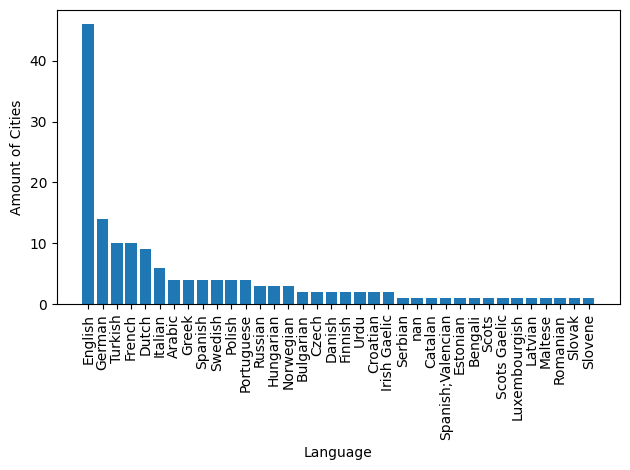

In [67]:
languages = {}
english_spoken = []
for item in data['Main Spoken Languages']:
    lst = str(item).split(",")
    eng = False
    for i in lst:
        i = i.strip()
        if i == 'English':
            eng = True
        if i not in languages:
            languages[i] = 1
        else:
            languages[i] += 1
    english_spoken.append(eng)

data['english_spoken'] = english_spoken

languages = sorted(languages.items(), key=lambda x: x[1], reverse=True)
languages
spoken_languages, counts = map(list, zip(*languages))
plt.bar(x=spoken_languages, height=counts)
plt.xticks(rotation=90)
plt.xlabel('Language')
plt.ylabel('Amount of Cities')
plt.tight_layout()
plt.show()

Q3a) Entries uploaded before April 2023 need to be updated. Which cities would
require an update?

In [68]:
data_before_april2023 = data[
    (data["Last Data Update"].dt.year < 2023)
    | ((data["Last Data Update"].dt.year == 2023) & (data["Last Data Update"].dt.month < 4))
]

In [69]:
print("the cities that must be updated are:")
data_before_april2023["City"]

the cities that must be updated are:


11                Basel
19               Munich
21    Frankfurt am Main
39                 Lyon
60               Venice
83           Gothenburg
Name: City, dtype: object

Q3b) How many days ago was the last update? On what day, month, and year did
it occur?


In [78]:
latest_date=data.sort_values(by="Last Data Update").iloc[-1,-2]
today=dt.date.today()
diference=today - latest_date.date()
print(f"the last update was at {latest_date.day}-{latest_date.month}-{latest_date.year},\nday:{latest_date.day}\nmonth:{latest_date.month}\nyear:{latest_date.year}")
print(f"It was {diference.days} days ago")

the last update was at 12-12-2024,
day:12
month:12
year:2024
It was 332 days ago


Q4a) How are the Unemployment Rate and GDP per Capita distributed and
related? What does this relationship suggest?

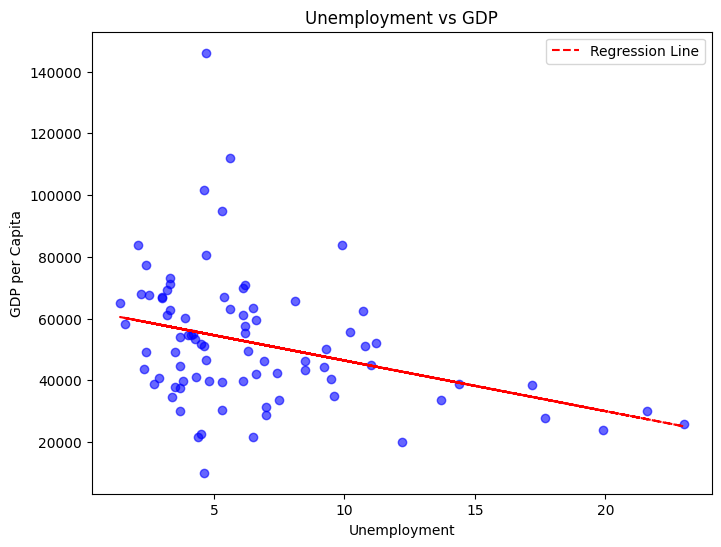

In [79]:
# Prepare data
x = data["Unemployment Rate"].values.reshape(-1, 1)
y = data["GDP per Capita"].values 

# Fit linear regression
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Close any existing figures (prevents leftover lines from previous interactive runs)
plt.close('all')

# Scatter plot
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(x, y, c='blue', alpha=0.6)

# Regression line
ax.plot(x, y_pred, color='red', linestyle='--', label='Regression Line')


ax.set_xlabel("Unemployment")
ax.set_ylabel("GDP per Capita")
ax.set_title("Unemployment vs GDP")
ax.legend()

# Make points clickable to show city
cursor = mplcursors.cursor(sc, hover=True)
@cursor.connect("add")
def on_add(sel):
    index = sel.index
    sel.annotation.set(text=data.iloc[index]["City"])

plt.show()

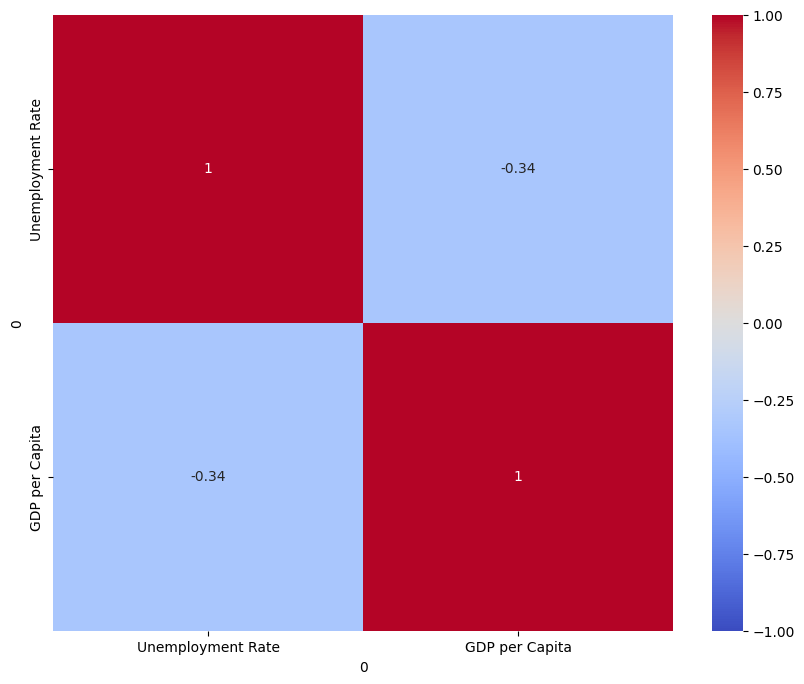

In [ ]:
corr=data[["Unemployment Rate", "GDP per Capita"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap="coolwarm", annot=True)
plt.show()


Through this regression line we can conclude that there exists a small negative corelation between unemployment and GDP 

Cities with the highest salary

In [ ]:
print("\nHigh Salary Cities:\n")
print(data[data["Average Monthly Salary"] > 1600].sort_values(by='Average Monthly Salary', ascending=False)[["City", "Average Monthly Salary"]])


High Salary Cities:

0                City  Average Monthly Salary
9              Zurich                  6636.0
11              Basel                  6366.0
10             Geneva                  5794.0
27         Copenhagen                  4200.0
61         Luxembourg                  4200.0
36           Helsinki                  3900.0
21  Frankfurt am Main                  3800.0
65          Amsterdam                  3750.0
69               Oslo                  3600.0
19             Munich                  3540.0
18            Hamburg                  3500.0
71          Stavanger                  3500.0
37            Tampere                  3500.0
64          The Hague                  3500.0
70             Bergen                  3500.0
28             Odense                  3400.0
3            Brussels                  3350.0
22          Stuttgart                  3300.0
38              Paris                  3300.0
20            Cologne                  3200.0
2           

Cities with low cost of living

In [ ]:
print("\nLow Cost of living:\n")
print(data[data["Average Cost of Living"] < 900].sort_values(by="Average Cost of Living", ascending=False)[["City", "Average Cost of Living"]])


Low Cost of living:

0    City  Average Cost of Living
86  Adana                   800.0


Difference between salary and cost of living


Positive difference between cost of living and salary:

0       City  avg salary - avg cost of living
11     Basel                           2127.0
37   Tampere                           1900.0
36  Helsinki                           1850.0
9     Zurich                           1774.0
10    Geneva                           1531.0

Negative difference between cost of living and salary:

0           City  avg salary - avg cost of living
75        Lisbon                           -380.0
76         Porto                           -300.0
46        Greece                           -150.0
47  Thessaloniki                           -100.0
77         Braga                           -100.0

Average difference:

619.5833333333334

The Country in crisis:

 Portugal : -207

The Country in best condition:

 Finland : 1875


<Axes: >

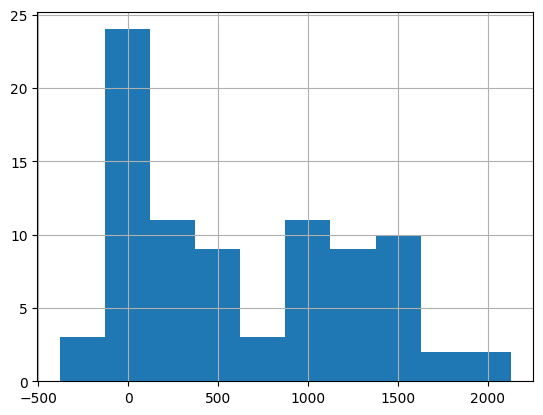

In [ ]:
data["avg salary - avg cost of living"] = data["Average Monthly Salary"] - data["Average Cost of Living"]
print("\nPositive difference between cost of living and salary:\n")
print(data[['City', "avg salary - avg cost of living"]].sort_values(by='avg salary - avg cost of living', ascending=False).head(5))

print("\nNegative difference between cost of living and salary:\n")
print(data[['City', "avg salary - avg cost of living"]].sort_values(by='avg salary - avg cost of living', ascending=True).head(5))

print("\nAverage difference:\n")
print(data["avg salary - avg cost of living"].mean())

differences_by_country = data.groupby('Country')['avg salary - avg cost of living'].mean()
print("\nThe Country in crisis:\n")
print(f"{differences_by_country.sort_values().head(1).index[0]} : {int(differences_by_country.sort_values().head(1).values[0])}")

print("\nThe Country in best condition:\n")
print(f"{differences_by_country.sort_values(ascending=False).head(1).index[0]} : {int(differences_by_country.sort_values(ascending=False).head(1).values[0])}")

data["avg salary - avg cost of living"].hist()

Correlation between salary and cost of living

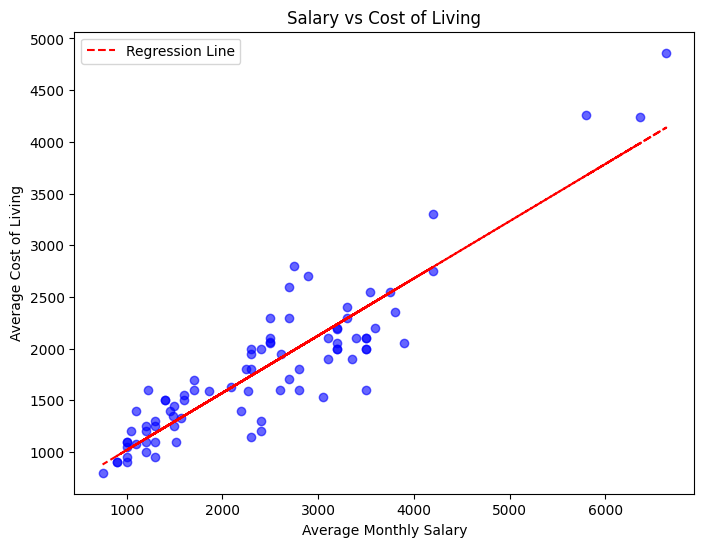

In [ ]:
# Prepare data
x = data["Average Monthly Salary"].values.reshape(-1, 1)
y = data["Average Cost of Living"].values

# Fit linear regression
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Close any existing figures (prevents leftover lines from previous interactive runs)
plt.close('all')

# Scatter plot
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(x, y, c='blue', alpha=0.6)

# Regression line
ax.plot(x, y_pred, color='red', linestyle='--', label='Regression Line')


ax.set_xlabel("Average Monthly Salary")
ax.set_ylabel("Average Cost of Living")
ax.set_title("Salary vs Cost of Living")
ax.legend()

# Make points clickable to show city
cursor = mplcursors.cursor(sc, hover=True)
@cursor.connect("add")
def on_add(sel):
    index = sel.index
    sel.annotation.set(text=data.iloc[index]["City"])

plt.show()

The most spoken languages

Cities with the most poeple unemployed:

In [ ]:
data['unemployed_amt'] = data['Working Age Population '] * (data['Unemployment Rate'] / 100)
data['unemployed_amt'] = data['unemployed_amt'].astype(np.int64)

print("\nCities with the most people unemployed:\n")
print(data[['City', 'unemployed_amt']]\
      .sort_values(by='unemployed_amt', ascending=False).head().set_index('City'))


Cities with the most people unemployed:

0       unemployed_amt
City                  
Naples          519495
London          504762
Madrid          498717
Ankara          492147
Greece          393393


Comparing English speaking cities with Non-English speaking cities

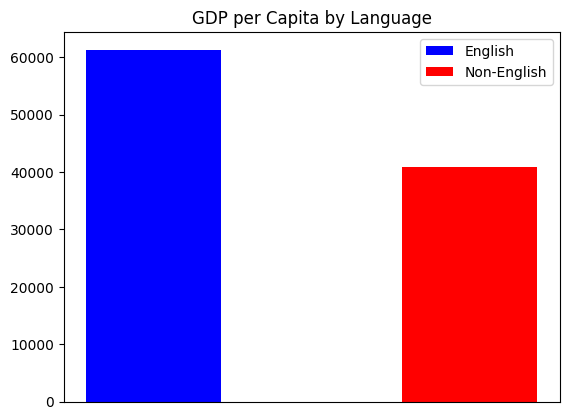

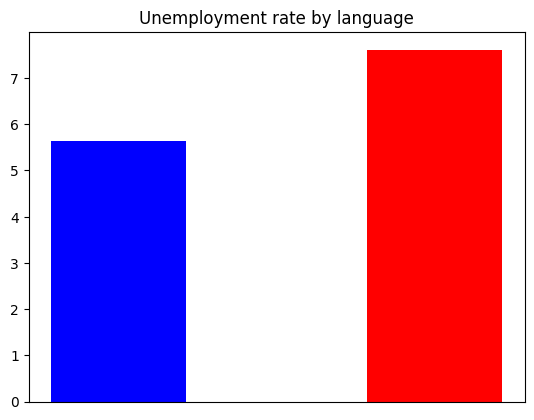

In [ ]:
english_speaking_cities = data[data['english_spoken'] == True]
non_english_speaking_cities = data[data['english_spoken'] == False]

gdp_eng = english_speaking_cities['GDP per Capita'].mean()
gdp_non_eng = non_english_speaking_cities['GDP per Capita'].mean()

unemployment_eng = english_speaking_cities['Unemployment Rate'].mean()
unemployment_non_eng = non_english_speaking_cities['Unemployment Rate'].mean()

fig, ax = plt.subplots()

x = np.array([0])

ax.bar(x - 0.35/2, [gdp_eng], 0.15, label='English', color='blue')
ax.bar(x + 0.35/2, [gdp_non_eng], 0.15, label='Non-English', color='red')
ax.set_title('GDP per Capita by Language')
ax.set_xticks([])
ax.legend()

fig2, ax2 = plt.subplots()
ax2.bar(x - 0.35/2, unemployment_eng, 0.15, label='English', color='blue')
ax2.bar(x + 0.35/2, unemployment_non_eng, 0.15, label='Non-English', color='red')
ax2.set_title('Unemployment rate by language')
ax2.set_xticks([])
ax.legend()

plt.show()

Negative Correlation between Unemployment rate and GDP per Capita

Analysis of the dates and time in which the dataset was edited

In [ ]:
print('\nCities which require updates (last update made was before April 2023): \n')
print(data[data['Last Data Update'] < '2023-04-01'][['City', 'Last Data Update']]\
      .sort_values(by='Last Data Update', ascending=True).set_index('City'))

print("\n\nThe most recent update: \n")
print(data[['City', 'Last Data Update']].sort_values(by='Last Data Update', ascending=False).head(1))


Cities which require updates (last update made was before April 2023): 

0                     Last Data Update
City                                  
Basel              2023-01-19 00:00:00
Frankfurt am Main  2023-02-04 00:00:00
Gothenburg         2023-03-10 00:00:00
Munich             2023-03-16 00:00:00
Venice             2023-03-23 00:00:00
Lyon               2023-03-31 00:00:00


The most recent update: 

0   City     Last Data Update
69  Oslo  2024-12-12 00:00:00
